# Data description


- Survived: 0 = Did not survive, 1 = Survived

- Pclass: Ticket class where 1 = First class, 2 = Second class, 3 = Third class. This can also be seen as a proxy for socio-economic status.

- Sex: Male or female

- Age: Age in years, fractional if less than 1

- SibSp: Number of siblings or spouses aboard the titanic

- Parch: Number of parents or children aboard the titanic

- Ticket: Passenger ticket number

- Fare: Passenger fare

- Cabin: Cabin number

- Embarked: Point of embarkation where C = Cherbourg, Q = Queenstown, S = Southampton

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix  
import seaborn as sns
import matplotlib.pyplot as plt


# Remove warnings
import warnings
warnings.filterwarnings('ignore')

## Import and read data

In [2]:
train = pd.read_csv("titanic_train.csv")
test = pd.read_csv("titanic_test.csv")

In [3]:
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)

Training set shape:  (891, 12)
Test set shape:  (418, 11)


In [4]:
# Non-null count and data types of the training and test set

train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [5]:
# Missing data in training set

train.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [6]:
# Missing data in test set

test.isnull().sum().sort_values(ascending = False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

# Feature Engineering

- Handle missing values
- Drop unnecessary
- Feature encoding

In [7]:
# Drop ticket and cabin features from training and test set

train = train.drop(['Ticket', 'Cabin'], axis = 1)
test = test.drop(['Ticket', 'Cabin'], axis = 1)

In [8]:
# Missing values in training set 

train.isnull().sum().sort_values(ascending = False)

Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
dtype: int64

In [9]:
# Compute the most frequent value of Embarked in training set ignoring any NaN values

mode = train['Embarked'].dropna().mode()[0]
print(mode)

# Fill missing value in Embarked

train['Embarked'].fillna(mode, inplace = True)

S


In [10]:
# Missing values in test set

test.isnull().sum().sort_values(ascending = False)

Age            86
Fare            1
PassengerId     0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [11]:
# Compute median of Fare and Age in train set 

median_fare = train['Fare'].dropna().median()
print('Median fare of train set:',median_fare)


median_age = train['Age'].dropna().median()
print('Median age of train set:',median_age)

Median fare of train set: 14.4542
Median age of train set: 28.0


In [12]:
# Fill missing value in Fare and Age with median

test['Fare'].fillna(median_fare, inplace = True)
train['Age'].fillna(median_age, inplace = True)
test['Age'].fillna(median_age, inplace = True)

In [13]:
# Combine training set and test set

combine = pd.concat([train, test], axis = 0).reset_index(drop = True)
combine.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
1304,1305,NaN,3,"Spector, Mr. Woolf",male,28.0,0,0,8.0500,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,8.0500,S
1308,1309,NaN,3,"Peter, Master. Michael J",male,28.0,1,1,22.3583,C


In [14]:
# Drop name and passengerID

combine = combine.drop(['Name','PassengerId'], axis = 1)
combine.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3,male,22.0,1,0,7.2500,S
1,1.0,1,female,38.0,1,0,71.2833,C
2,1.0,3,female,26.0,0,0,7.9250,S
3,1.0,1,female,35.0,1,0,53.1000,S
4,0.0,3,male,35.0,0,0,8.0500,S


In [15]:
combine.shape

(1309, 8)

In [16]:
# Missing values in the combined dataset

combine.isnull().sum().sort_values(ascending = False)

Survived    418
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

We can ignore missing values in the Survived column because all of them are from the test set. Now we need to fill missing values in the Age column.

The goal is to use features that are most correlated with Age to predict the values for Age. But first, we need to convert Sex into numerical values where 0 = male and 1 = female. 

In [17]:
le = LabelEncoder()

combine['Sex']= le.fit_transform(combine['Sex'])
combine['Embarked']= le.fit_transform(combine['Embarked'])
combine.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3,1,22.0,1,0,7.2500,2
1,1.0,1,0,38.0,1,0,71.2833,0
2,1.0,3,0,26.0,0,0,7.9250,2
3,1.0,1,0,35.0,1,0,53.1000,2
4,0.0,3,1,35.0,0,0,8.0500,2


### Make sure there are no missing values

In [18]:
print(train.isnull().sum().sort_values(ascending = False))

print('-'*60)

print(test.isnull().sum().sort_values(ascending = False))

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
------------------------------------------------------------
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


## Data split

In [19]:
# Separate training and test set from the combined dataframe

train = combine[:len(train)]
test = combine[len(train):]

In [20]:
print('Train shape:', train.shape)

print('Test shape:', test.shape)

Train shape: (891, 8)
Test shape: (418, 8)


In [21]:
# Typecast Survived

train['Survived'] = train['Survived'].astype('category')
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3,1,22.0,1,0,7.2500,2
1,1.0,1,0,38.0,1,0,71.2833,0
2,1.0,3,0,26.0,0,0,7.9250,2
3,1.0,1,0,35.0,1,0,53.1000,2
4,0.0,3,1,35.0,0,0,8.0500,2


# Classification

In [22]:
X = train.drop('Survived', axis=1)
y1 = train['Survived']

Z = test.drop('Survived', axis=1)
y2 = test['Survived']

In [23]:
print(X.shape)
print(y1.shape)

print(Z.shape)
print(y2.shape)

(891, 7)
(891,)
(418, 7)
(418,)


In [24]:
lg = LogisticRegression()

lg.fit(X, y1)

y_pred = lg.predict(X)

### Predict train set

In [25]:
results = confusion_matrix(y1, y_pred)

print ("Confusion Matrix of train set")
print(results)

Confusion Matrix of train set
[[474  75]
 [103 239]]


In [26]:
rep = classification_report(y1, y_pred) 
print ("Report of train data")
print(rep)

Report of train data
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       549
         1.0       0.76      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.79       891
weighted avg       0.80      0.80      0.80       891



### Predict test set

In [27]:
y_pred_test = lg.predict(Z)

y_pred_test.shape

(418,)

In [28]:
y_pred_test[:40]

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0.])

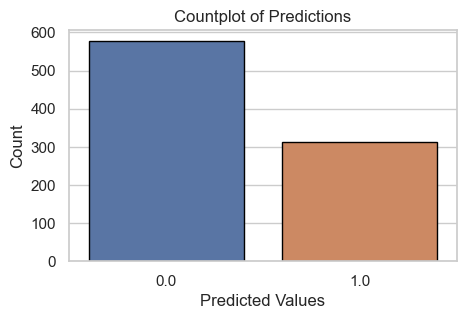

In [29]:
# Set the style for better aesthetics
sns.set(style="whitegrid")

# Create a countplot using Seaborn
plt.figure(figsize=(5, 3))
sns.countplot(x=y_pred, edgecolor='black')

# Set plot title and labels
plt.title("Countplot of Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Count")

# Show the plot
plt.show()

# Logical Error Detection and Rectification

In this notebook, there is a **logical error** in the provided code. Your task is to:

1. **Identify** the logical error in the code.
2. **Explain** why it is an error and what impact it has on the results.
3. **Correct** the code to eliminate the logical error.
4. **Compare Results**:
    - Show the difference in the output before and after fixing the error.
    - Provide a brief analysis of how the correction improves the results.